In [67]:
!pip install nbconvert[webpdf] pyppeteer

     |████████████████████████████████| 83 kB 4.5 MB/s eta 0:00:011
     |████████████████████████████████| 145 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 14.9 MB/s eta 0:00:01
  Created wheel for websockets: filename=websockets-8.1-cp39-cp39-macosx_10_9_x86_64.whl size=65237 sha256=ef269db275936eb0494e0daf336cdf0420a10dc3089a782025e538b3ec222b5d
  Stored in directory: /Users/tsharma/Library/Caches/pip/wheels/d8/b9/a0/b97b211aeda2ebd6ac2e43fc300d308dbf1f9df520ed390cae
Successfully built websockets
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution from skimage import filters
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import histogram, cumulative_distribution import imageio
import imageio
from skimage.util import img_as_ubyte
#image = imageio.imread('photo.jpg')

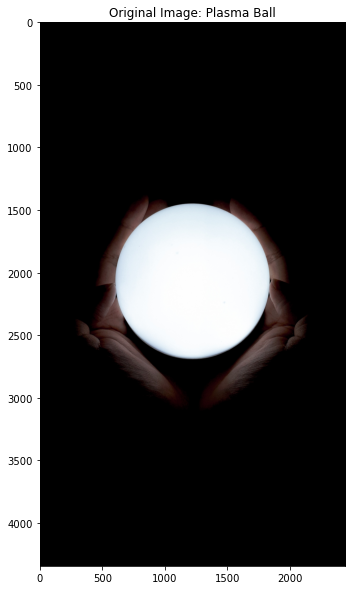

In [7]:
# Load the image & remove the alpha or opacity channel (transparency) 
dark_image = imageio.imread('photo.jpg')[:,:,:3]

# Visualize the image
plt.figure(figsize=(10, 10))
plt.title('Original Image: Plasma Ball')
plt.imshow(dark_image)
plt.show()

In [28]:
def new_color_fun(image): #define a function whihc takes a single argument
    #calculate the color over cast for each chanel
    red_channel = image[:,:,0] # RGBA where o stand for red and so on 
    green_channel = image[:,:,1]
    blue_channel = image[:,:,2]
    
    
    
    ## create a dataframe to store the statistics 
    channel_stats = pd.DataFrame(columns=['Mean', 'Std', 'Min', 'Median', 
 'P_80', 'P_90', 'P_99', 'Max'])
    
    # Let's compute and store statistics for each color channel 
    
    for channel, name in zip([red_channel, green_channel, blue_channel], ['red', 'green' ,'blue']):
        mean = np.mean(channel)
        std = np.std(channel)
        minimum = np.min(channel)
        median = np.median(channel)
        p_80 = np.percentile(channel, 80)
        p_90 = np.percentile(channel, 90)
        p_99 = np.percentile(channel, 99)
        maximum = np.max(channel)
        
        #Storing the computed statistics in the DataFrame: where loc[name] is used as index
        channel_stats.loc[name] = [mean, std, minimum, median, p_80, p_90, p_99, maximum]#DataFrame was initially created

    return channel_stats


    

In [29]:
new_color_fun(dark_image)

,Mean,Std,Min,Median,P_80,P_90,P_99,Max
red,31.181137,76.674395,0.0,0.0,0.0,220.0,254.0,255.0
green,30.329876,77.861710,0.0,0.0,0.0,234.0,254.0,255.0
blue,30.625139,79.030574,0.0,0.0,0.0,243.0,255.0,255.0


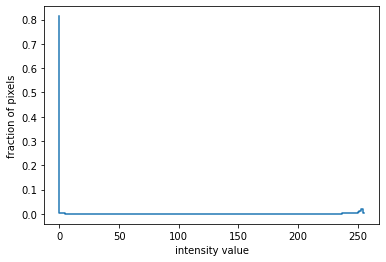

In [32]:
# Histogram plot

#converting the dark_image (which is assumed to be in RGB format) to grayscale using the rgb2gray function.
#The resulting grayscale image will have pixel values in the range [0, 1], with 0 being black and 1 being white
#img_as_ubyte is used to convert these values into 8-bit unsigned integers, resulting in values in the range [0, 255].
#This processed image is stored in the variable dark_image_intensity.
dark_image_intensity = img_as_ubyte(rgb2gray(dark_image))
freq, bins = histogram(dark_image_intensity)
plt.step(bins, freq*1.0/freq.sum())
plt.xlabel('intensity value')
plt.ylabel('fraction of pixels');

In [44]:
def plot_cdf(image):
    """
    Plot the cumulative distribution function of an image.
 
    Parameters:
    image (ndarray): Input image.
    """
    
    # convert the image into gray if needed
    if len(image.shape) == 3: 
        image = rgb2gray(image[:,:,:3]) # select all the rows, all the columns, and the first three channels
    
    # Compute the cumulative distribution function
    intensity = np.round(image * 255).astype(np.uint8)
    freq, bins = cumulative_distribution(intensity)
    
    # Plot the actual and target CDFs
    target_bins = np.arange(256)
    target_freq = np.linspace(0, 1, len(target_bins))
    plt.step(bins, freq, c='b', label='Actual CDF')
    plt.plot(target_bins, target_freq, c='r', label='Target CDF')
    
    # Plot an example lookup
    example_intensity = 50
    example_target = np.interp(freq[example_intensity], target_freq, target_bins)
    plt.plot([example_intensity, example_intensity, target_bins[-11], target_bins[-11]],
             [0, freq[example_intensity], freq[example_intensity], 0], 
             'k--', 
             label=f'Example lookup ({example_intensity} -> {example_target:.0f})')
 
    # Customize the plot
    plt.legend()
    plt.xlim(0, 255)
    plt.ylim(0, 1)
    plt.xlabel('Intensity Values')
    plt.ylabel('Cumulative Fraction of Pixels')
    plt.title('Cumulative Distribution Function')
    
    return freq, bins, target_freq, target_bins


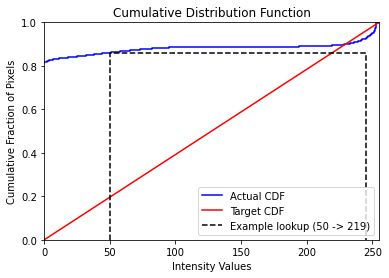

In [50]:
dark_image = imageio.imread('photo.jpg')
freq, bins, target_freq, target_bins = plot_cdf(dark_image);

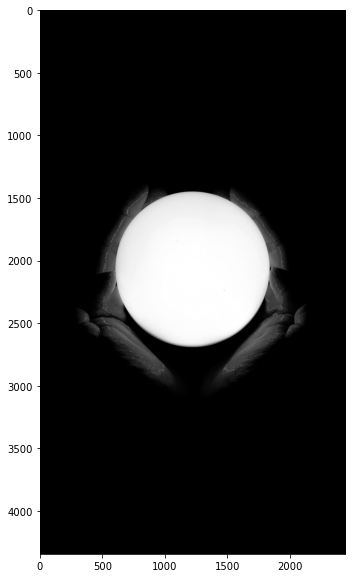

In [51]:
# Sample conversion of intensity values from actual value of 50 to target value of 230
dark_image_230 = dark_image_intensity.copy()
dark_image_230[dark_image_230==50] = 230 #looks for any pixel with an intensity value of 50 and replaces that value with 230
plt.figure(figsize=(10,10))
plt.imshow(dark_image_230,cmap='gray');

/Users/tsharma/opt/anaconda3/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


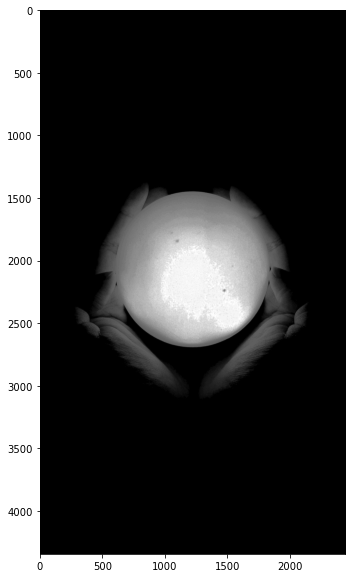

In [52]:
# Display the result after replacing all actual values to target values
new_vals = np.interp(freq, target_freq, target_bins)#np.interp() function computes the intensity values to be used in replacing the original pixel intensities by interpolating between the actual and target CDFs
dark_image_eq = img_as_ubyte(new_vals[img_as_ubyte(rgb2gray(dark_image[:,:,:3]))].astype(int))
plt.figure(figsize=(10,10))
plt.imshow(dark_image_eq, cmap='gray');

In [58]:
def custom_rgb_adjustment(image, target_freq):
 target_bins = np.arange(256)
 freq_bins = [cumulative_distribution(image[:, :, i]) for i in range(3)]
 adjusted_channels = []

 # Pad frequencies with min frequency
 padded_freqs = []
 for i in range(len(freq_bins)):
    if len(freq_bins[i][0]) < 256:
        
        frequencies = list(freq_bins[i][0])
        min_pad = [min(frequencies)] * (256 - len(frequencies))
        frequencies = min_pad + frequencies
        
        
    else:
            
            frequencies = freq_bins[i][0]
            padded_freqs.append(np.array(frequencies))
            

    for n in range(3):
        
        interpolation = np.interp(padded_freqs[n], target_freq, target_bins)
        adjusted_channel = img_as_ubyte(interpolation[image[:, :, n]].astype(int))
        adjusted_channels.append([adjusted_channel])

        adjusted_image = np.dstack((adjusted_channels[0][0], adjusted_channels[1][0], adjusted_channels[2][0]))

    return adjusted_image

In [61]:
# Linear
target_bins = np.arange(256)


# Sigmoid
def sigmoid_cdf(x, a=1):
 return (1 + np.tanh(a * x)) / 2


# Exponential
def exponential_cdf(x, alpha=1):
 return 1 - np.exp(-alpha * x)


# Power
def power_law_cdf(x, alpha=1):
 return x ** alpha


# Other techniques:
def adaptive_histogram_equalization(image, clip_limit=0.03, tile_size=(8, 8)):
 clahe = exposure.equalize_adapthist(
 image, clip_limit=clip_limit, nbins=256, kernel_size=(tile_size[0], tile_size[1]))
 return clahe


def gamma_correction(image, gamma=1.0):
 corrected_image = exposure.adjust_gamma(image, gamma)
 return corrected_image


def contrast_stretching_percentile(image, lower_percentile=5, upper_percentile=95):
 in_range = tuple(np.percentile(image, (lower_percentile, upper_percentile)))
 stretched_image = exposure.rescale_intensity(image, in_range)
 return stretched_image


def unsharp_masking(image, radius=5, amount=1.0):
 blurred_image = filters.gaussian(image, sigma=radius, multichannel=True)
 sharpened_image = (image + (image - blurred_image) * amount).clip(0, 1)
 return sharpened_image


def equalize_hist_rgb(image):
 equalized_image = exposure.equalize_hist(image)
 return equalized_image


def equalize_hist_hsv(image):
 hsv_image = color.rgb2hsv(image[:,:,:3])
 hsv_image[:, :, 2] = exposure.equalize_hist(hsv_image[:, :, 2])
 hsv_adjusted = color.hsv2rgb(hsv_image)
 return hsv_adjusted


def equalize_hist_yuv(image):
 yuv_image = color.rgb2yuv(image[:,:,:3])
 yuv_image[:, :, 0] = exposure.equalize_hist(yuv_image[:, :, 0])
 yuv_adjusted = color.yuv2rgb(yuv_image)
 return yuv_adjusted

In [64]:
import numpy as np

def custom_rgb_adjustment(image, target_freq):
    # This is a mockup for the function, which will adjust the image based on the target frequencies.
    
    adjusted_channels = []
    
    for channel_index in range(3):  # Assuming RGB channels
        channel = image[:, :, channel_index]
        # Do adjustments to the channel here using target_freq...
        # This is a mockup, so I'm just normalizing the channel here as an example.
        adjusted_channel = (channel - channel.min()) / (channel.max() - channel.min())
        adjusted_channels.append(adjusted_channel)

    # Safe Access: Ensure that adjusted_channels has the required indices before accessing them
    if len(adjusted_channels) >= 3:
        adjusted_image = np.dstack((adjusted_channels[0], adjusted_channels[1], adjusted_channels[2]))
    else:
        print("Error: Not all channels were processed.")
        # Return the original image as a default value
        return image

    return adjusted_image

# The following is the main script block you provided:

# Assuming the necessary functions and variables are defined...

linear = custom_rgb_adjustment(dark_image, np.linspace(0, 1, len(target_bins)))
sigmoid = custom_rgb_adjustment(dark_image, sigmoid_cdf((target_bins - 128) / 64, a=1))
exponential = custom_rgb_adjustment(dark_image, exponential_cdf(target_bins / 255, alpha=3))
power = custom_rgb_adjustment(dark_image, power_law_cdf(target_bins / 255, alpha=2))

clahe_image = adaptive_histogram_equalization(dark_image, clip_limit=0.09, tile_size=(50, 50))
gamma_corrected_image = gamma_correction(dark_image, gamma=0.4)
sharpened_image = unsharp_masking(dark_image, radius=10, amount=-0.98)
cs_image = contrast_stretching_percentile(dark_image, 0, 70)

equalized_rgb = equalize_hist_rgb(dark_image)
equalized_hsv = equalize_hist_hsv(dark_image)
equalized_yuv = equalize_hist_yuv(dark_image)


/Users/tsharma/opt/anaconda3/lib/python3.9/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


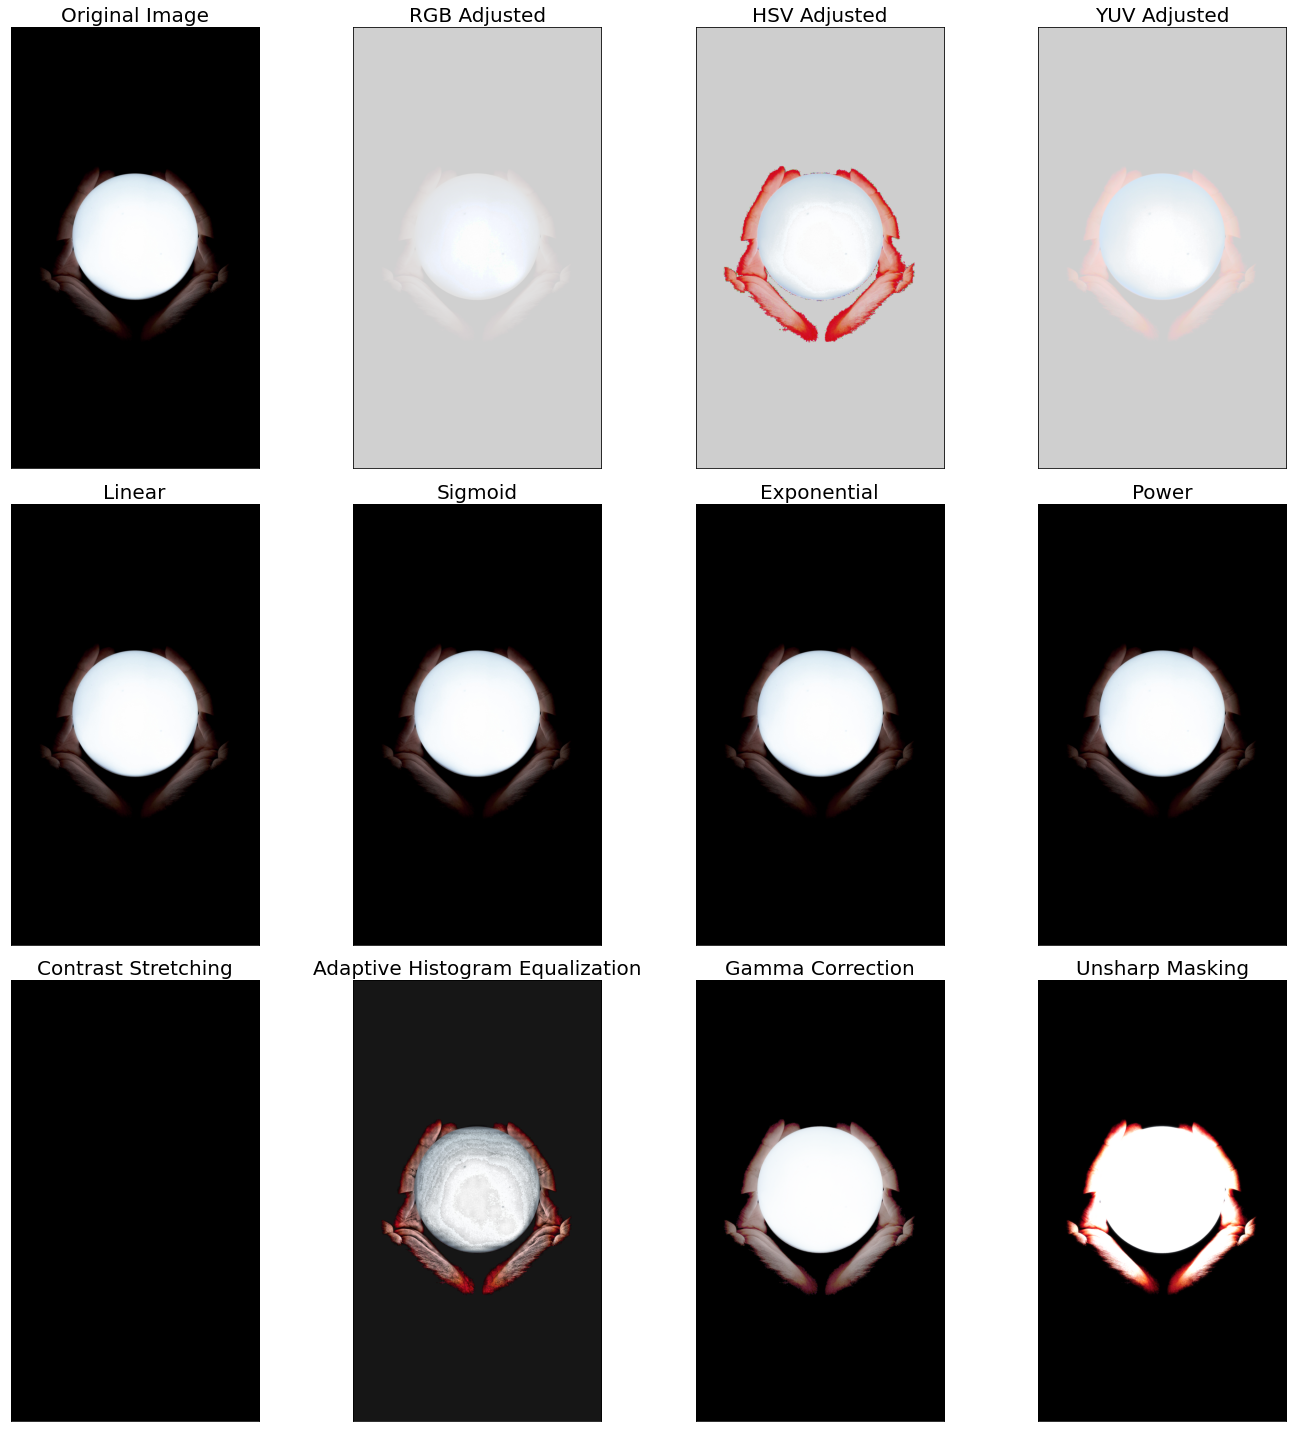

In [66]:

# Plot
fig, axes = plt.subplots(3, 4, figsize=(20, 20))

# Original image
axes[0, 0].imshow(dark_image)
axes[0, 0].set_title('Original Image', fontsize=20)

# Histogram Equalization: RGB Adjusted
axes[0, 1].imshow(equalized_rgb)
axes[0, 1].set_title('RGB Adjusted', fontsize=20)

# HSV Adjusted
axes[0, 2].imshow(equalized_hsv)
axes[0, 2].set_title('HSV Adjusted', fontsize=20)

# YUV Adjusted
axes[0, 3].imshow(equalized_yuv)
axes[0, 3].set_title('YUV Adjusted', fontsize=20)

# Linear CDF
axes[1, 0].imshow(linear)
axes[1, 0].set_title('Linear', fontsize=20)

# Sigmoid CDF
axes[1, 1].imshow(sigmoid)
axes[1, 1].set_title('Sigmoid', fontsize=20)

# Exponential CDF
axes[1, 2].imshow(exponential)
axes[1, 2].set_title('Exponential', fontsize=20)

# Power CDF
axes[1, 3].imshow(power)
axes[1, 3].set_title('Power', fontsize=20)

# Contrast Stretching
axes[2, 0].imshow(cs_image)
axes[2, 0].set_title('Contrast Stretching', fontsize=20)

# Adaptive Histogram Equalization (CLAHE)
axes[2, 1].imshow(clahe_image)
axes[2, 1].set_title('Adaptive Histogram Equalization', fontsize=20)

# Gamma Correction
axes[2, 2].imshow(gamma_corrected_image)
axes[2, 2].set_title('Gamma Correction', fontsize=20)

# Unsharp Masking
axes[2, 3].imshow(sharpened_image)
axes[2, 3].set_title('Unsharp Masking', fontsize=20)

# Remove axis ticks and labels
for ax in axes.flatten():
 ax.set_xticks([])
 ax.set_yticks([])

plt.tight_layout()
plt.show()